This is similar to the 'CNN' notebook, but will use pure tensorflow.

In [1]:
# Standard scientific Python imports
import matplotlib.pyplot as plt
%matplotlib inline

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics

# The digits dataset
digits = datasets.load_digits()

import tensorflow as tf
#sess = tf.InteractiveSession()
import numpy as np

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.

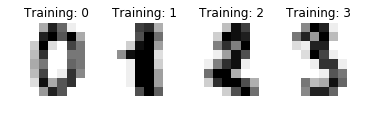

In [2]:
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

In [3]:
# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
digits.target_cat = tf.one_hot(digits.target, 10)

n_samples = len(digits.images)
data = digits.images
X_train = data[:n_samples // 2]
X_test = data[n_samples // 2:]
y_train = digits.target_cat[:n_samples // 2]
y_test = digits.target_cat[n_samples // 2:]

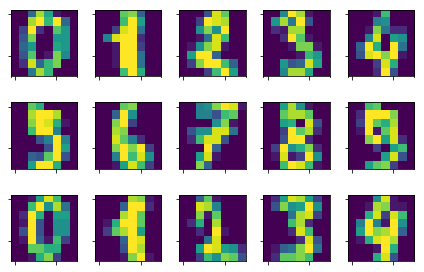

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=5)
for j in range(3):
    for i in range(5):
        axes[j, i].imshow(X_train[j*5 + i])
        axes[j, i].set_xticklabels([])
        axes[j, i].set_yticklabels([])
plt.tight_layout()

In [5]:
x = tf.placeholder(tf.float32, shape=[None, 8, 8])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
#W = tf.Variable(tf.zeros([64, 10]))
#b = tf.Variable(tf.zeros([10]))
#y = tf.nn.softmax(tf.matmul(x, W) + b)

In [6]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

Here's the structure we want to mimic:
<ol>
    <li>Input: N x 8 x 8
        <ul><li>Reshape to N x 8 x 8 x 1</li></ul>
    <li>Convolutional (2x2, 10 features)
        <ul><li>Weights: 2 x 2 x 1 x 10</li>
            <li>Bias: 10</li></ul>
    <li>Convolutional (2x2, 16 features)
        <ul><li>Weights: 2 x 2 x 10 x 16</li>
            <li>Bias: 16</li></ul>
    <li>Max Pooling (2x2)
        <ul><li>Cuts rows and cols by half</li></ul>
    <li>Dropout (25%)
    <li>Flatten
        <ul><li>Reshape to N x (8x8x16/4=256)</li></ul>
    <li>Dense (10, softmax)
        <ul><li>Weights: 256 x 10</li>
            <li>Bias: 10</li></ul>
</ol>

In [7]:
x_image = tf.reshape(x, [-1, 8, 8, 1]) #[-1==automatic depending on next 3 dims, width, height, color channels]

W_conv1 = weight_variable([2, 2, 1, 10]) #[rows, cols, input channels, num features per window]
b_conv1 = bias_variable([10]) #1 for each output channel
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

W_conv2 = weight_variable([2, 2, 10, 16]) #[rows, cols, input matches output of prev, output]
b_conv2 = bias_variable([16])
h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

keep_prob = tf.placeholder(tf.float32)
h_pool2_drop = tf.nn.dropout(h_pool2, keep_prob)

h_pool2_flat = tf.reshape(h_pool2_drop, [-1, 256])
W_dense3 = weight_variable([256, 10])
b_dense3 = bias_variable([10])
y_conv = tf.matmul(h_pool2_flat, W_dense3) + b_dense3

In [8]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [10]:
#This takes awhile without a GPU...
patience = 20
train_acc = [0] * patience
runs = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(20000):
        indices = np.random.randint(X_train.shape[0], size=100)
        batch_xs = X_train[indices, :]
        batch_ys = sess.run(tf.gather(y_train, indices))
        batch = [batch_xs, batch_ys]
        
        if i % 20 == 0:
            train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
            if i % 200 == 0:
                print('step %d, training accuracy %g' % (i, train_accuracy))
            
            #Early stopping with patience as set above
            train_acc.append(train_accuracy)
            if train_acc[-1 * patience - 1] > max(train_acc[-1 * patience:]):
                print('Stopping after {0:d} rounds after topping out at {1:.1f}% accuracy'.format(
                    i, 100 * train_acc[-1 * patience - 1]))
                print(train_acc[-1 * patience - 1:])
                runs = i
                break
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
    saver = tf.train.Saver()
    saver.save(sess, 'cnn-tf_model',global_step=3760)

    print('test accuracy %g' % accuracy.eval(feed_dict={
        x: X_test, y_: sess.run(y_test), keep_prob: 1.0}))

step 0, training accuracy 0.08
step 200, training accuracy 0.46
step 400, training accuracy 0.69
step 600, training accuracy 0.82
step 800, training accuracy 0.87
step 1000, training accuracy 0.96
step 1200, training accuracy 0.9
step 1400, training accuracy 0.89
step 1600, training accuracy 0.97
step 1800, training accuracy 0.99
step 2000, training accuracy 0.99
step 2200, training accuracy 0.96
Stopping after 2340 rounds after topping out at 100.0% accuracy
[1.0, 0.94999999, 0.93000001, 0.99000001, 0.99000001, 0.97000003, 0.97000003, 0.99000001, 0.97000003, 0.98000002, 0.97000003, 0.98000002, 0.94999999, 0.95999998, 0.97000003, 0.99000001, 0.97000003, 0.98000002, 0.94999999, 0.99000001, 0.95999998]
test accuracy 0.941046


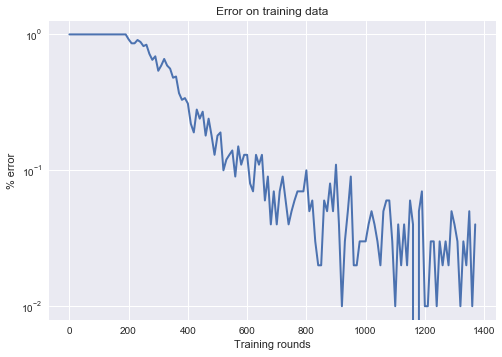

In [11]:
import seaborn as sns
plt.plot([x*10 for x in range(len(train_acc))], [1 - x for x in train_acc], lw=2)
plt.title('Error on training data')
plt.xlabel('Training rounds')
plt.ylabel('% error')
plt.gca().set_yscale("log", nonposy='clip')

This looks like it got to around 90% accuracy within 500 iterations and is already around 99% in 1500 (95% on test through 2000). The TensorFlow example used a larger network (an extra pooling layer, an extra dense layer, 2-4x larger convolutional layers, and final dense layers with ~10x as many features) and a larger dataset to get to ~99.7%.